In [20]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [22]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop
#         dX = dout @ np.linalg.inv(W_fixed) # my backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward include in dcross_entropy
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
#         dy =  dy @ self.W_fixed[2].T # done
        dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dy *= dy - dy_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
#             dy =  dy @ self.W_fixed[2].T # done
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[2].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dy *= dy - dy_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_prob = nn.test(X_test)
        loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [23]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.2772 valid loss: 2.2862, valid accuracy: 0.1342
Iter-20 train loss: 2.2749 valid loss: 2.2861, valid accuracy: 0.1348
Iter-30 train loss: 2.3030 valid loss: 2.2860, valid accuracy: 0.1350
Iter-40 train loss: 2.2949 valid loss: 2.2858, valid accuracy: 0.1356
Iter-50 train loss: 2.3111 valid loss: 2.2857, valid accuracy: 0.1358
Iter-60 train loss: 2.2718 valid loss: 2.2856, valid accuracy: 0.1360
Iter-70 train loss: 2.2926 valid loss: 2.2855, valid accuracy: 0.1364
Iter-80 train loss: 2.2622 valid loss: 2.2853, valid accuracy: 0.1374
Iter-90 train loss: 2.2831 valid loss: 2.2852, valid accuracy: 0.1372
Iter-100 train loss: 2.2656 valid loss: 2.2851, valid accuracy: 0.1380
Iter-110 train loss: 2.2801 valid loss: 2.2849, valid accuracy: 0.1396
Iter-120 train loss: 2.2621 valid loss: 2.2848, valid accuracy: 0.1400
Iter-130 train loss: 2.2726 valid loss: 2.2847, valid accuracy: 0.1404
Iter-140 train loss: 2.2821 valid loss: 2.2846, valid accuracy: 0.1406
Iter-150 train 

Iter-1170 train loss: 2.2558 valid loss: 2.2719, valid accuracy: 0.1848
Iter-1180 train loss: 2.2690 valid loss: 2.2718, valid accuracy: 0.1848
Iter-1190 train loss: 2.2746 valid loss: 2.2717, valid accuracy: 0.1856
Iter-1200 train loss: 2.2715 valid loss: 2.2715, valid accuracy: 0.1868
Iter-1210 train loss: 2.2791 valid loss: 2.2714, valid accuracy: 0.1870
Iter-1220 train loss: 2.2598 valid loss: 2.2713, valid accuracy: 0.1874
Iter-1230 train loss: 2.2909 valid loss: 2.2712, valid accuracy: 0.1876
Iter-1240 train loss: 2.2883 valid loss: 2.2711, valid accuracy: 0.1886
Iter-1250 train loss: 2.2883 valid loss: 2.2709, valid accuracy: 0.1892
Iter-1260 train loss: 2.2761 valid loss: 2.2708, valid accuracy: 0.1892
Iter-1270 train loss: 2.2792 valid loss: 2.2707, valid accuracy: 0.1896
Iter-1280 train loss: 2.2575 valid loss: 2.2706, valid accuracy: 0.1898
Iter-1290 train loss: 2.2731 valid loss: 2.2705, valid accuracy: 0.1908
Iter-1300 train loss: 2.2745 valid loss: 2.2703, valid accuracy:

Iter-2310 train loss: 2.2522 valid loss: 2.2583, valid accuracy: 0.2216
Iter-2320 train loss: 2.2631 valid loss: 2.2582, valid accuracy: 0.2218
Iter-2330 train loss: 2.2652 valid loss: 2.2581, valid accuracy: 0.2220
Iter-2340 train loss: 2.2552 valid loss: 2.2580, valid accuracy: 0.2218
Iter-2350 train loss: 2.2698 valid loss: 2.2578, valid accuracy: 0.2228
Iter-2360 train loss: 2.2457 valid loss: 2.2577, valid accuracy: 0.2232
Iter-2370 train loss: 2.2464 valid loss: 2.2576, valid accuracy: 0.2228
Iter-2380 train loss: 2.2505 valid loss: 2.2575, valid accuracy: 0.2234
Iter-2390 train loss: 2.2426 valid loss: 2.2574, valid accuracy: 0.2236
Iter-2400 train loss: 2.2713 valid loss: 2.2573, valid accuracy: 0.2236
Iter-2410 train loss: 2.2661 valid loss: 2.2571, valid accuracy: 0.2240
Iter-2420 train loss: 2.2402 valid loss: 2.2570, valid accuracy: 0.2244
Iter-2430 train loss: 2.2693 valid loss: 2.2569, valid accuracy: 0.2248
Iter-2440 train loss: 2.2740 valid loss: 2.2568, valid accuracy:

Iter-3450 train loss: 2.2620 valid loss: 2.2451, valid accuracy: 0.2612
Iter-3460 train loss: 2.2546 valid loss: 2.2450, valid accuracy: 0.2616
Iter-3470 train loss: 2.2466 valid loss: 2.2449, valid accuracy: 0.2624
Iter-3480 train loss: 2.2392 valid loss: 2.2447, valid accuracy: 0.2624
Iter-3490 train loss: 2.2220 valid loss: 2.2446, valid accuracy: 0.2626
Iter-3500 train loss: 2.2075 valid loss: 2.2445, valid accuracy: 0.2626
Iter-3510 train loss: 2.2579 valid loss: 2.2444, valid accuracy: 0.2628
Iter-3520 train loss: 2.2587 valid loss: 2.2443, valid accuracy: 0.2630
Iter-3530 train loss: 2.2489 valid loss: 2.2442, valid accuracy: 0.2632
Iter-3540 train loss: 2.2660 valid loss: 2.2441, valid accuracy: 0.2632
Iter-3550 train loss: 2.2712 valid loss: 2.2440, valid accuracy: 0.2636
Iter-3560 train loss: 2.2206 valid loss: 2.2439, valid accuracy: 0.2648
Iter-3570 train loss: 2.2514 valid loss: 2.2437, valid accuracy: 0.2648
Iter-3580 train loss: 2.2468 valid loss: 2.2436, valid accuracy:

Iter-4590 train loss: 2.2212 valid loss: 2.2322, valid accuracy: 0.2950
Iter-4600 train loss: 2.2173 valid loss: 2.2321, valid accuracy: 0.2958
Iter-4610 train loss: 2.2313 valid loss: 2.2320, valid accuracy: 0.2960
Iter-4620 train loss: 2.2481 valid loss: 2.2319, valid accuracy: 0.2964
Iter-4630 train loss: 2.2516 valid loss: 2.2318, valid accuracy: 0.2964
Iter-4640 train loss: 2.2273 valid loss: 2.2317, valid accuracy: 0.2968
Iter-4650 train loss: 2.2222 valid loss: 2.2315, valid accuracy: 0.2970
Iter-4660 train loss: 2.2325 valid loss: 2.2314, valid accuracy: 0.2970
Iter-4670 train loss: 2.2520 valid loss: 2.2313, valid accuracy: 0.2970
Iter-4680 train loss: 2.2392 valid loss: 2.2312, valid accuracy: 0.2970
Iter-4690 train loss: 2.2213 valid loss: 2.2311, valid accuracy: 0.2966
Iter-4700 train loss: 2.2369 valid loss: 2.2310, valid accuracy: 0.2968
Iter-4710 train loss: 2.2226 valid loss: 2.2309, valid accuracy: 0.2972
Iter-4720 train loss: 2.2161 valid loss: 2.2308, valid accuracy:

Iter-5730 train loss: 2.2477 valid loss: 2.2195, valid accuracy: 0.3166
Iter-5740 train loss: 2.2567 valid loss: 2.2194, valid accuracy: 0.3172
Iter-5750 train loss: 2.2024 valid loss: 2.2193, valid accuracy: 0.3170
Iter-5760 train loss: 2.2410 valid loss: 2.2192, valid accuracy: 0.3172
Iter-5770 train loss: 2.2327 valid loss: 2.2191, valid accuracy: 0.3178
Iter-5780 train loss: 2.2389 valid loss: 2.2189, valid accuracy: 0.3176
Iter-5790 train loss: 2.2559 valid loss: 2.2188, valid accuracy: 0.3188
Iter-5800 train loss: 2.2474 valid loss: 2.2187, valid accuracy: 0.3196
Iter-5810 train loss: 2.2471 valid loss: 2.2186, valid accuracy: 0.3200
Iter-5820 train loss: 2.2229 valid loss: 2.2185, valid accuracy: 0.3202
Iter-5830 train loss: 2.2101 valid loss: 2.2184, valid accuracy: 0.3202
Iter-5840 train loss: 2.2281 valid loss: 2.2183, valid accuracy: 0.3208
Iter-5850 train loss: 2.1969 valid loss: 2.2182, valid accuracy: 0.3208
Iter-5860 train loss: 2.2215 valid loss: 2.2181, valid accuracy:

Iter-6870 train loss: 2.1986 valid loss: 2.2071, valid accuracy: 0.3386
Iter-6880 train loss: 2.2239 valid loss: 2.2070, valid accuracy: 0.3386
Iter-6890 train loss: 2.2075 valid loss: 2.2069, valid accuracy: 0.3384
Iter-6900 train loss: 2.2156 valid loss: 2.2068, valid accuracy: 0.3392
Iter-6910 train loss: 2.2087 valid loss: 2.2067, valid accuracy: 0.3392
Iter-6920 train loss: 2.2343 valid loss: 2.2066, valid accuracy: 0.3396
Iter-6930 train loss: 2.2029 valid loss: 2.2064, valid accuracy: 0.3396
Iter-6940 train loss: 2.2148 valid loss: 2.2063, valid accuracy: 0.3400
Iter-6950 train loss: 2.2238 valid loss: 2.2062, valid accuracy: 0.3396
Iter-6960 train loss: 2.1820 valid loss: 2.2061, valid accuracy: 0.3396
Iter-6970 train loss: 2.2148 valid loss: 2.2060, valid accuracy: 0.3394
Iter-6980 train loss: 2.1941 valid loss: 2.2059, valid accuracy: 0.3394
Iter-6990 train loss: 2.2267 valid loss: 2.2058, valid accuracy: 0.3392
Iter-7000 train loss: 2.2499 valid loss: 2.2057, valid accuracy:

Iter-8010 train loss: 2.1754 valid loss: 2.1950, valid accuracy: 0.3550
Iter-8020 train loss: 2.2083 valid loss: 2.1949, valid accuracy: 0.3552
Iter-8030 train loss: 2.1963 valid loss: 2.1948, valid accuracy: 0.3552
Iter-8040 train loss: 2.1785 valid loss: 2.1947, valid accuracy: 0.3554
Iter-8050 train loss: 2.2085 valid loss: 2.1946, valid accuracy: 0.3554
Iter-8060 train loss: 2.2143 valid loss: 2.1945, valid accuracy: 0.3562
Iter-8070 train loss: 2.1881 valid loss: 2.1944, valid accuracy: 0.3564
Iter-8080 train loss: 2.1605 valid loss: 2.1943, valid accuracy: 0.3564
Iter-8090 train loss: 2.2248 valid loss: 2.1942, valid accuracy: 0.3562
Iter-8100 train loss: 2.1654 valid loss: 2.1941, valid accuracy: 0.3564
Iter-8110 train loss: 2.1940 valid loss: 2.1940, valid accuracy: 0.3566
Iter-8120 train loss: 2.1934 valid loss: 2.1939, valid accuracy: 0.3566
Iter-8130 train loss: 2.2026 valid loss: 2.1938, valid accuracy: 0.3568
Iter-8140 train loss: 2.2231 valid loss: 2.1937, valid accuracy:

Iter-9150 train loss: 2.1328 valid loss: 2.1832, valid accuracy: 0.3658
Iter-9160 train loss: 2.1683 valid loss: 2.1831, valid accuracy: 0.3662
Iter-9170 train loss: 2.2239 valid loss: 2.1830, valid accuracy: 0.3664
Iter-9180 train loss: 2.1992 valid loss: 2.1829, valid accuracy: 0.3668
Iter-9190 train loss: 2.1522 valid loss: 2.1828, valid accuracy: 0.3666
Iter-9200 train loss: 2.2019 valid loss: 2.1827, valid accuracy: 0.3664
Iter-9210 train loss: 2.1848 valid loss: 2.1826, valid accuracy: 0.3670
Iter-9220 train loss: 2.1597 valid loss: 2.1825, valid accuracy: 0.3674
Iter-9230 train loss: 2.1762 valid loss: 2.1824, valid accuracy: 0.3674
Iter-9240 train loss: 2.1606 valid loss: 2.1823, valid accuracy: 0.3666
Iter-9250 train loss: 2.1555 valid loss: 2.1822, valid accuracy: 0.3672
Iter-9260 train loss: 2.1702 valid loss: 2.1821, valid accuracy: 0.3668
Iter-9270 train loss: 2.1872 valid loss: 2.1820, valid accuracy: 0.3670
Iter-9280 train loss: 2.2244 valid loss: 2.1819, valid accuracy:

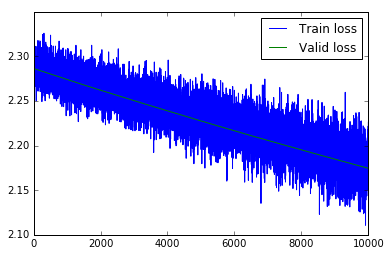

In [24]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

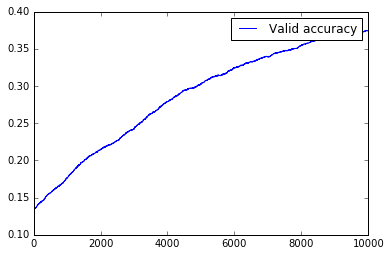

In [25]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()